# Subclutering of midline cells

In [1]:
# loading packages
library(Seurat)
library(ggplot2)
library(magrittr)
library(data.table)
library(Matrix)
library(dplyr)
library(tibble)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#loading data
seu_HQC <- readRDS(file = "../../data/seurat_object/Set3/seu_HQC_Set3.obj")

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


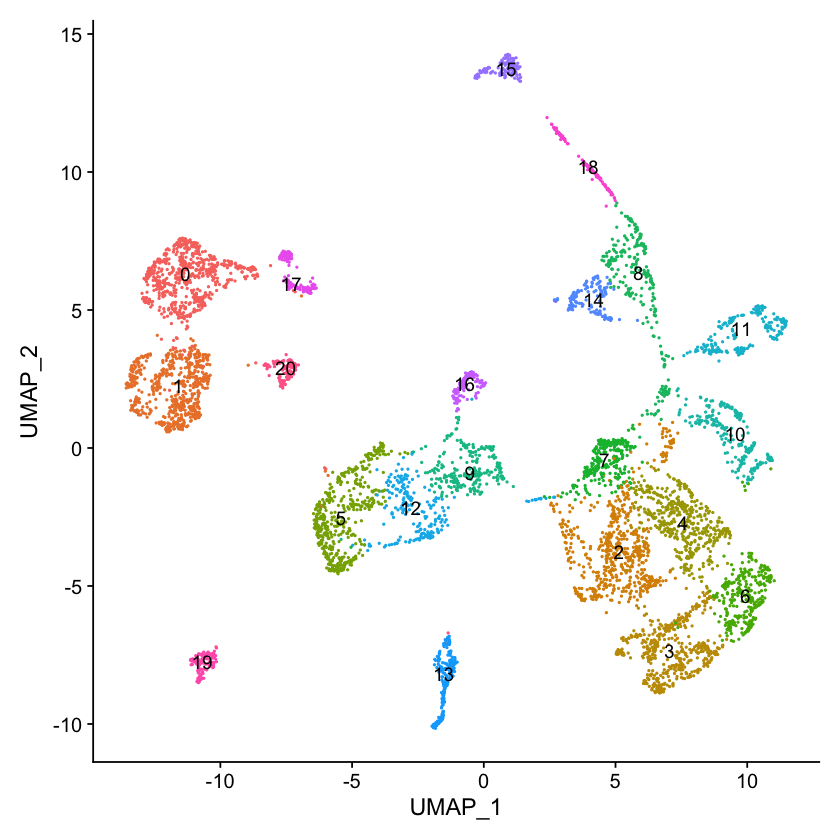

In [3]:
DimPlot(seu_HQC, reduction =  "umap", label = TRUE) + NoLegend()

## picking up target clusters

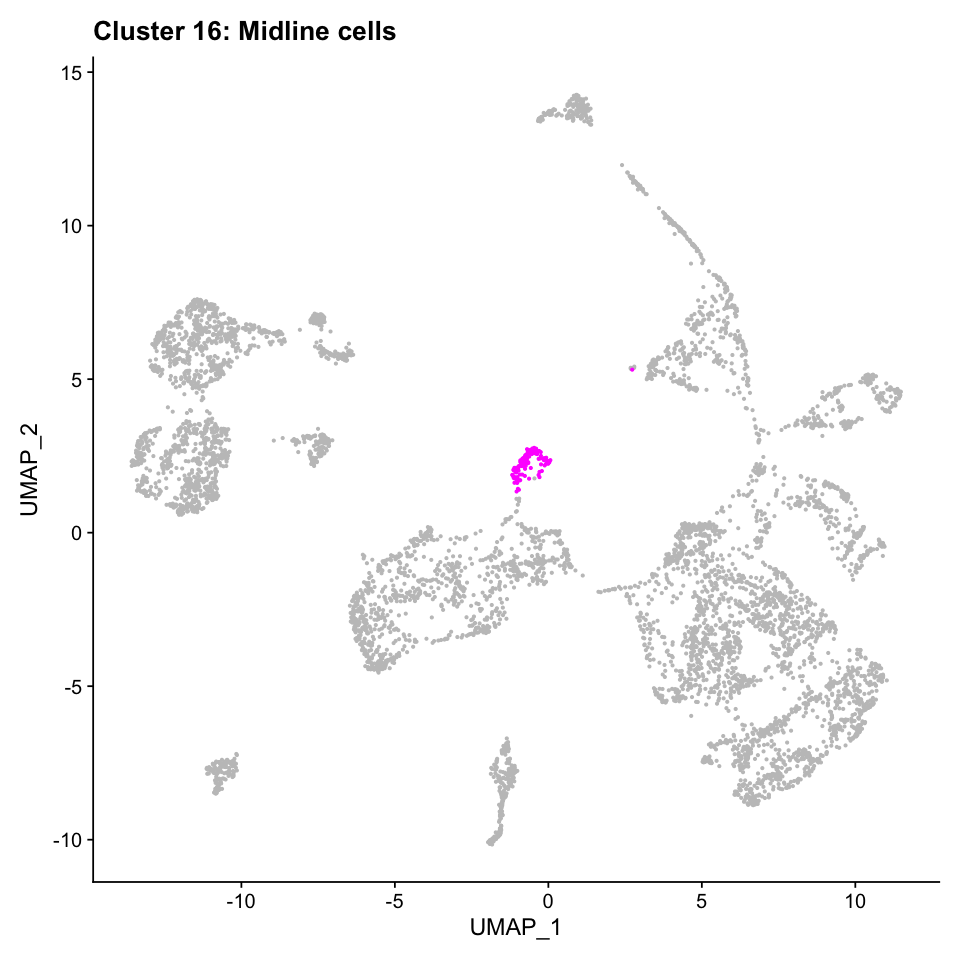

In [4]:
options(repr.plot.width=8, repr.plot.height=8)
highlight.cells <- WhichCells(seu_HQC,idents = c(16))
DimPlot(seu_HQC, reduction =  "umap", cells.highlight = highlight.cells, pt.size = 0.5, sizes.highlight = 0.5,
        cols.highlight = 'magenta', label = FALSE) + NoLegend() + ggtitle('Cluster 16: Midline cells')

In [5]:
seu_HQC_midline <- subset(seu_HQC, ident = c("16"))
seu_HQC_midline

An object of class Seurat 
28756 features across 135 samples within 2 assays 
Active assay: SCT (11250 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

## Clustering
Num of cells < 500  
Skipping re-normalize

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


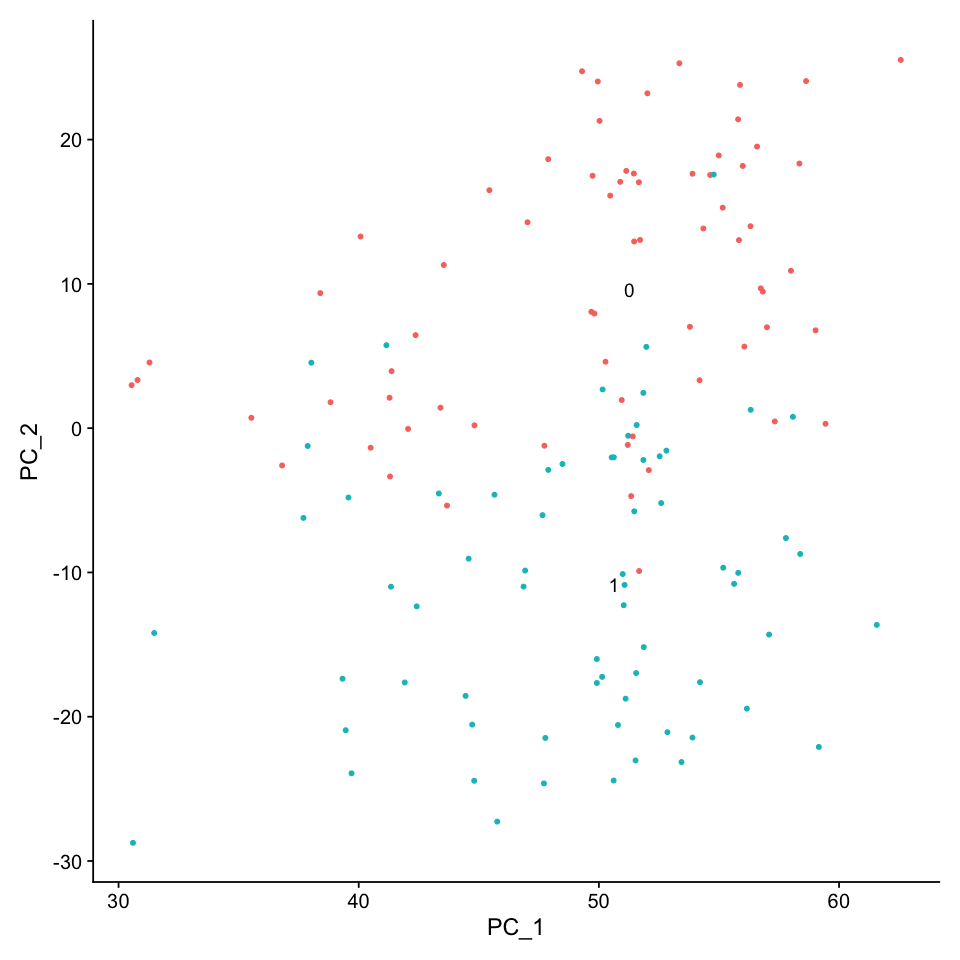

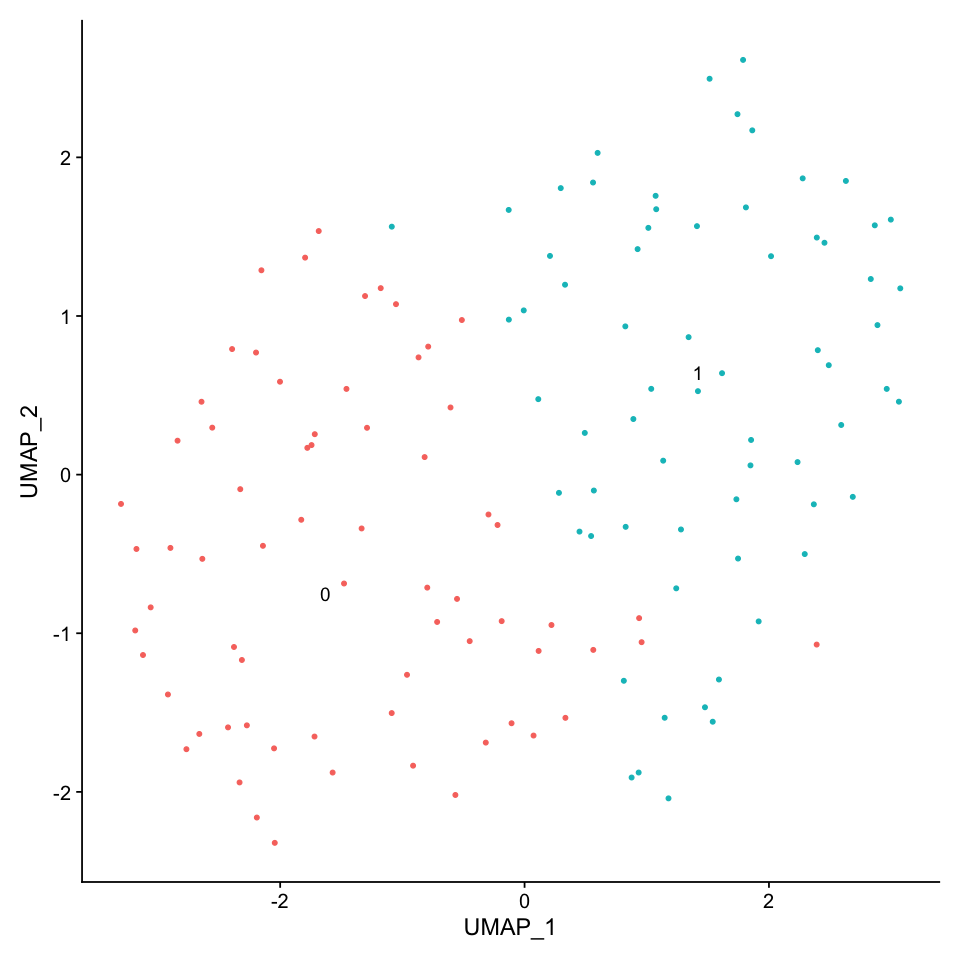

In [6]:
options(repr.plot.width=8, repr.plot.height=8)
seu_HQC_midline <- RunPCA(seu_HQC_midline, verbose = FALSE)
seu_HQC_midline <- RunUMAP(seu_HQC_midline, dims = 1:30, verbose = FALSE)
seu_HQC_midline <- FindNeighbors(seu_HQC_midline, dims = 1:30, verbose = FALSE)
seu_HQC_midline <- FindClusters(seu_HQC_midline, verbose = FALSE)
DimPlot(seu_HQC_midline, reduction =  "pca", label = TRUE) + NoLegend()
DimPlot(seu_HQC_midline, reduction =  "umap", label = TRUE) + NoLegend()

In [7]:
all.markers.midline <- FindAllMarkers(object = seu_HQC_midline, only.pos = TRUE)


Calculating cluster 0

Calculating cluster 1



In [8]:
nrow(all.markers.midline)
all.markers.midline.top10 <- all.markers.midline %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
nrow(all.markers.midline.top10)

[1] 90

[1] 20

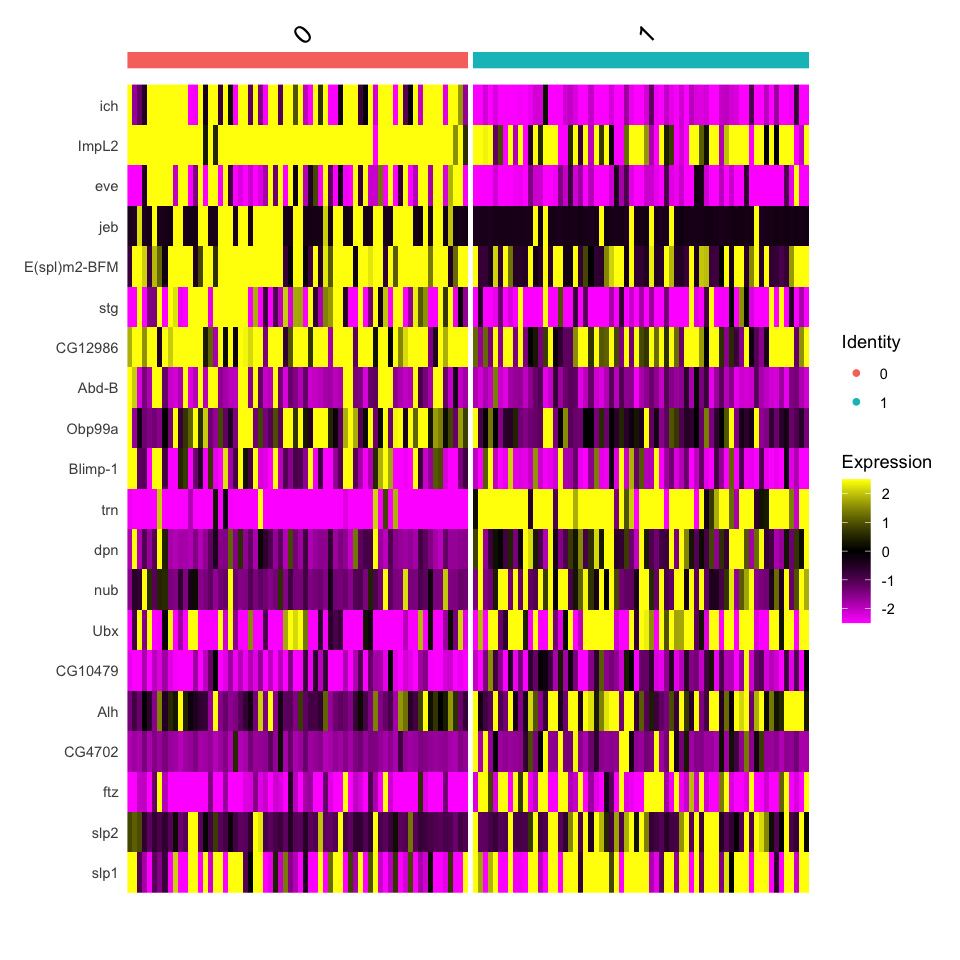

In [9]:
options(repr.plot.width=8, repr.plot.height=8)
DoHeatmap(seu_HQC_midline, features = c(all.markers.midline.top10$gene))

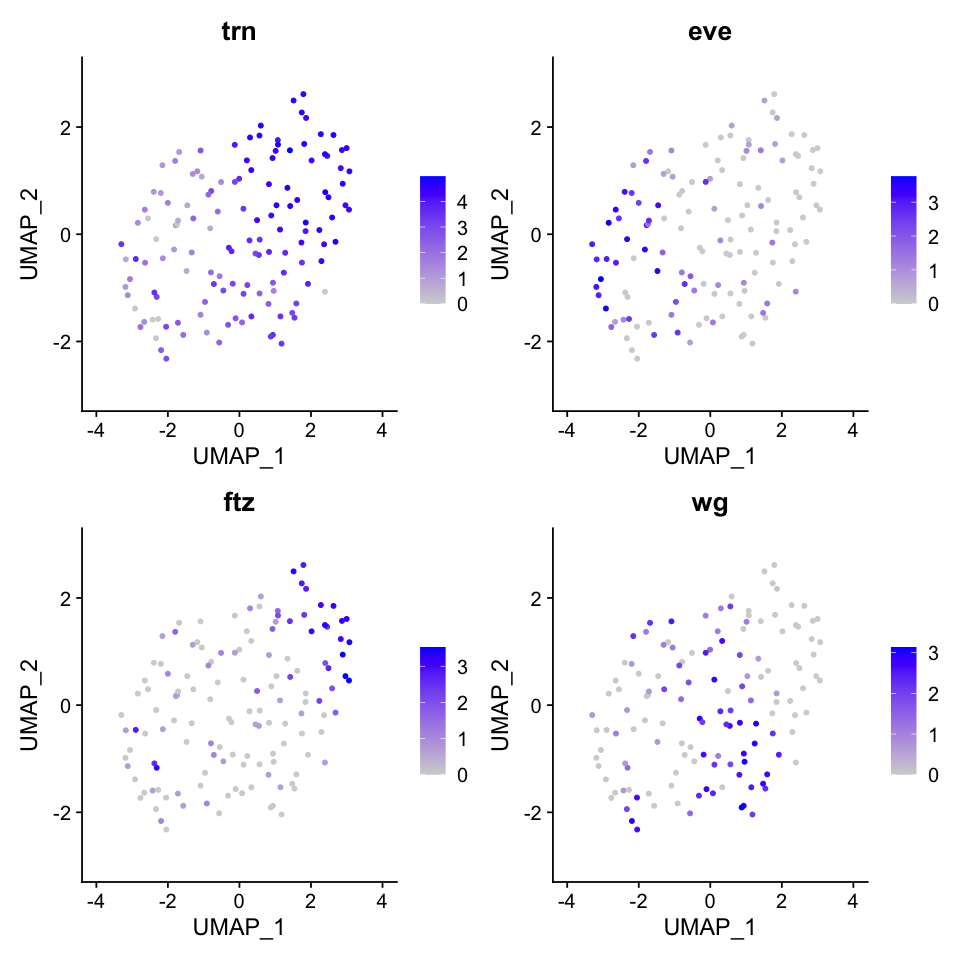

In [10]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu_HQC_midline, reduction = 'umap', features = c('trn','eve','ftz','wg'))

## Add annotation

In [11]:
manual_ID <- as.data.frame(seu_HQC_midline$seurat_clusters)
colnames(manual_ID) <- c('manual_ID')
head(manual_ID)
manual_ID$manual_ID <- dplyr::recode(manual_ID$manual_ID, 
                                        "0" = "midline_cells_odd", #trn-, eve+
                                        "1" = "midline_cells_even" #trn+, ftz+
                                     )
head(manual_ID)

,manual_ID
,<fct>
AACCATGTCTTCCCGA,1
AACGGGACACATTGTG,1
AAGACTCAGACTTGTC,1
AAGATAGGTACTGCGC,1
AAGGTAACATCCCACT,1
ACACTGACAAGAAACT,0


,manual_ID
,<fct>
AACCATGTCTTCCCGA,midline_cells_even
AACGGGACACATTGTG,midline_cells_even
AAGACTCAGACTTGTC,midline_cells_even
AAGATAGGTACTGCGC,midline_cells_even
AAGGTAACATCCCACT,midline_cells_even
ACACTGACAAGAAACT,midline_cells_odd


In [12]:
seu_HQC_midline$manual_ID <- manual_ID

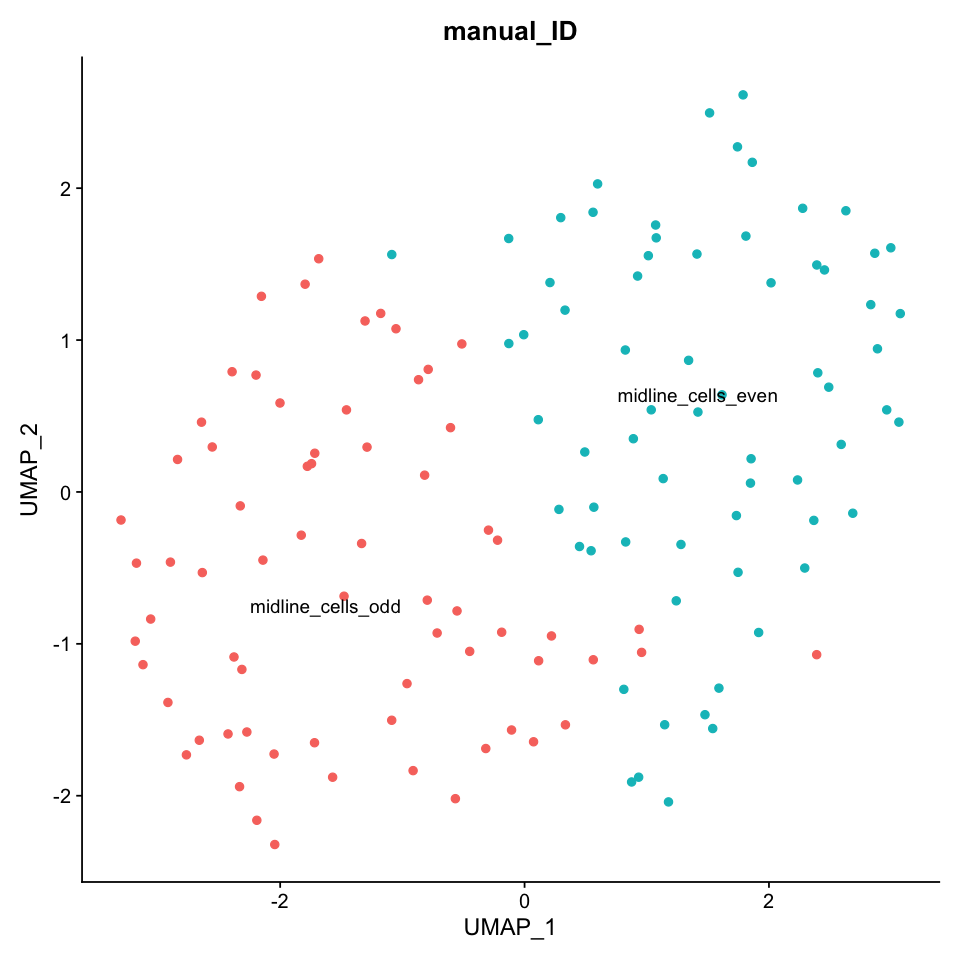

In [13]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_HQC_midline, reduction =  "umap", group.by = "manual_ID", label = TRUE, pt.size=2) + NoLegend()

In [14]:
write.table(manual_ID, file="./manual_ID_list/seu_HQC_midlines_manualID.txt",sep="\t",col.names=T,row.names=T,quote=F)

In [15]:
Idents(seu_HQC_midline) <- 'manual_ID'
all.markers <- FindAllMarkers(seu_HQC_midline, only.pos = T)
dim(all.markers)

Calculating cluster midline_cells_odd

Calculating cluster midline_cells_even



[1] 90  7

Saving 7 x 7 in image



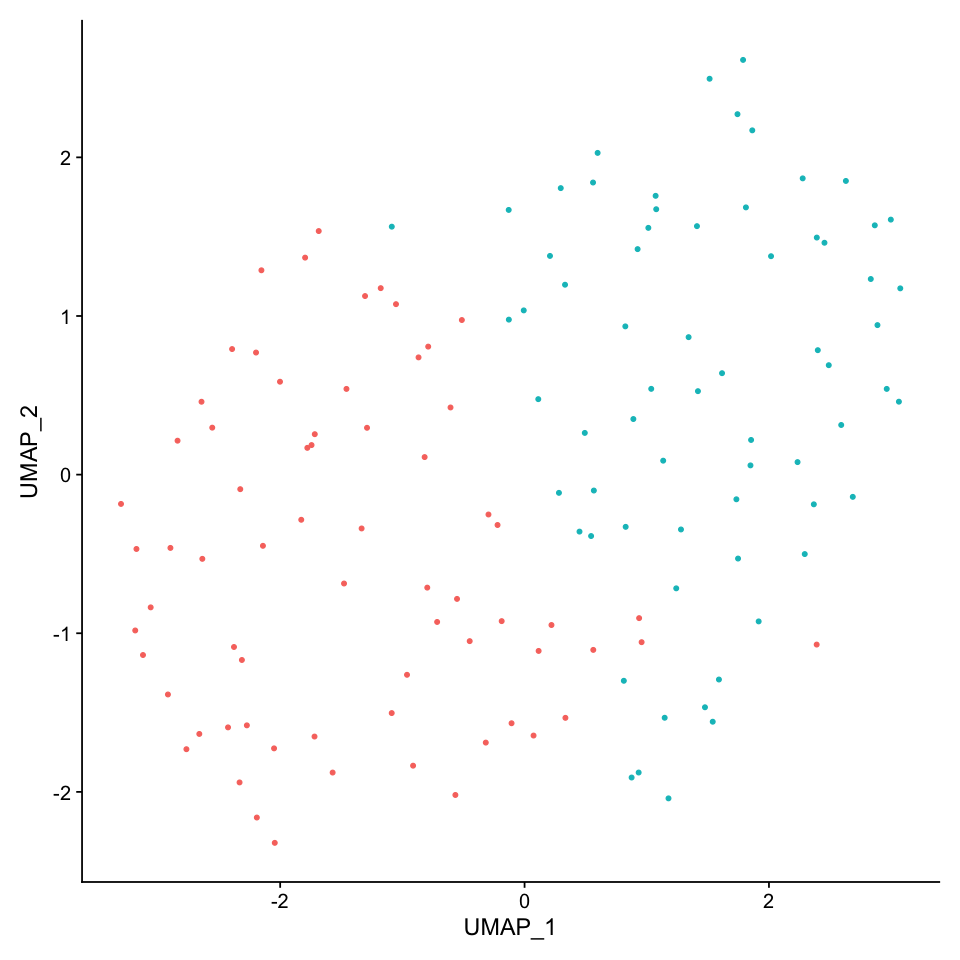

In [16]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu_HQC_midline, reduction =  "umap", label = FALSE) + NoLegend() 

fig
ggsave(fig, file = "./figures/07_subclustering_midline&polecells_manualID/midline_umap1.eps", dpi = 300)

Saving 7 x 7 in image



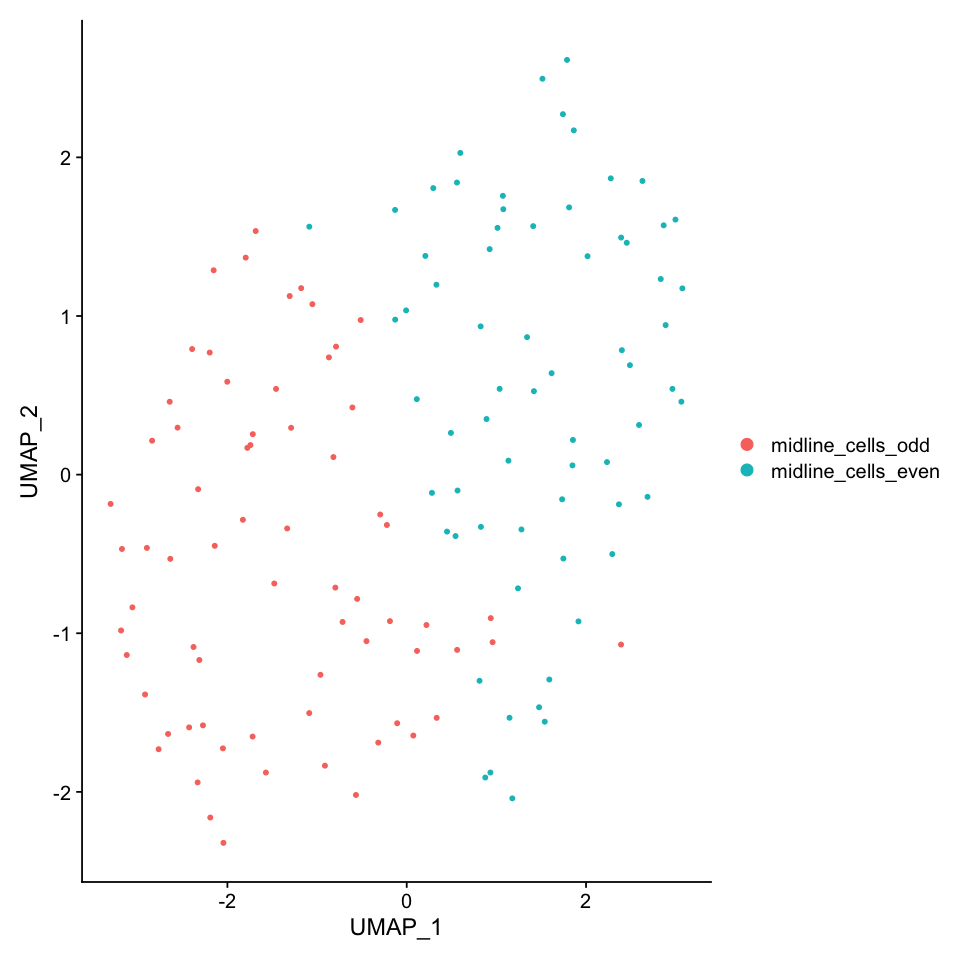

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu_HQC_midline, reduction =  "umap", label = FALSE) 

fig
ggsave(fig, file = "./figures/07_subclustering_midline&polecells_manualID/midline_umap2.eps", dpi = 300)

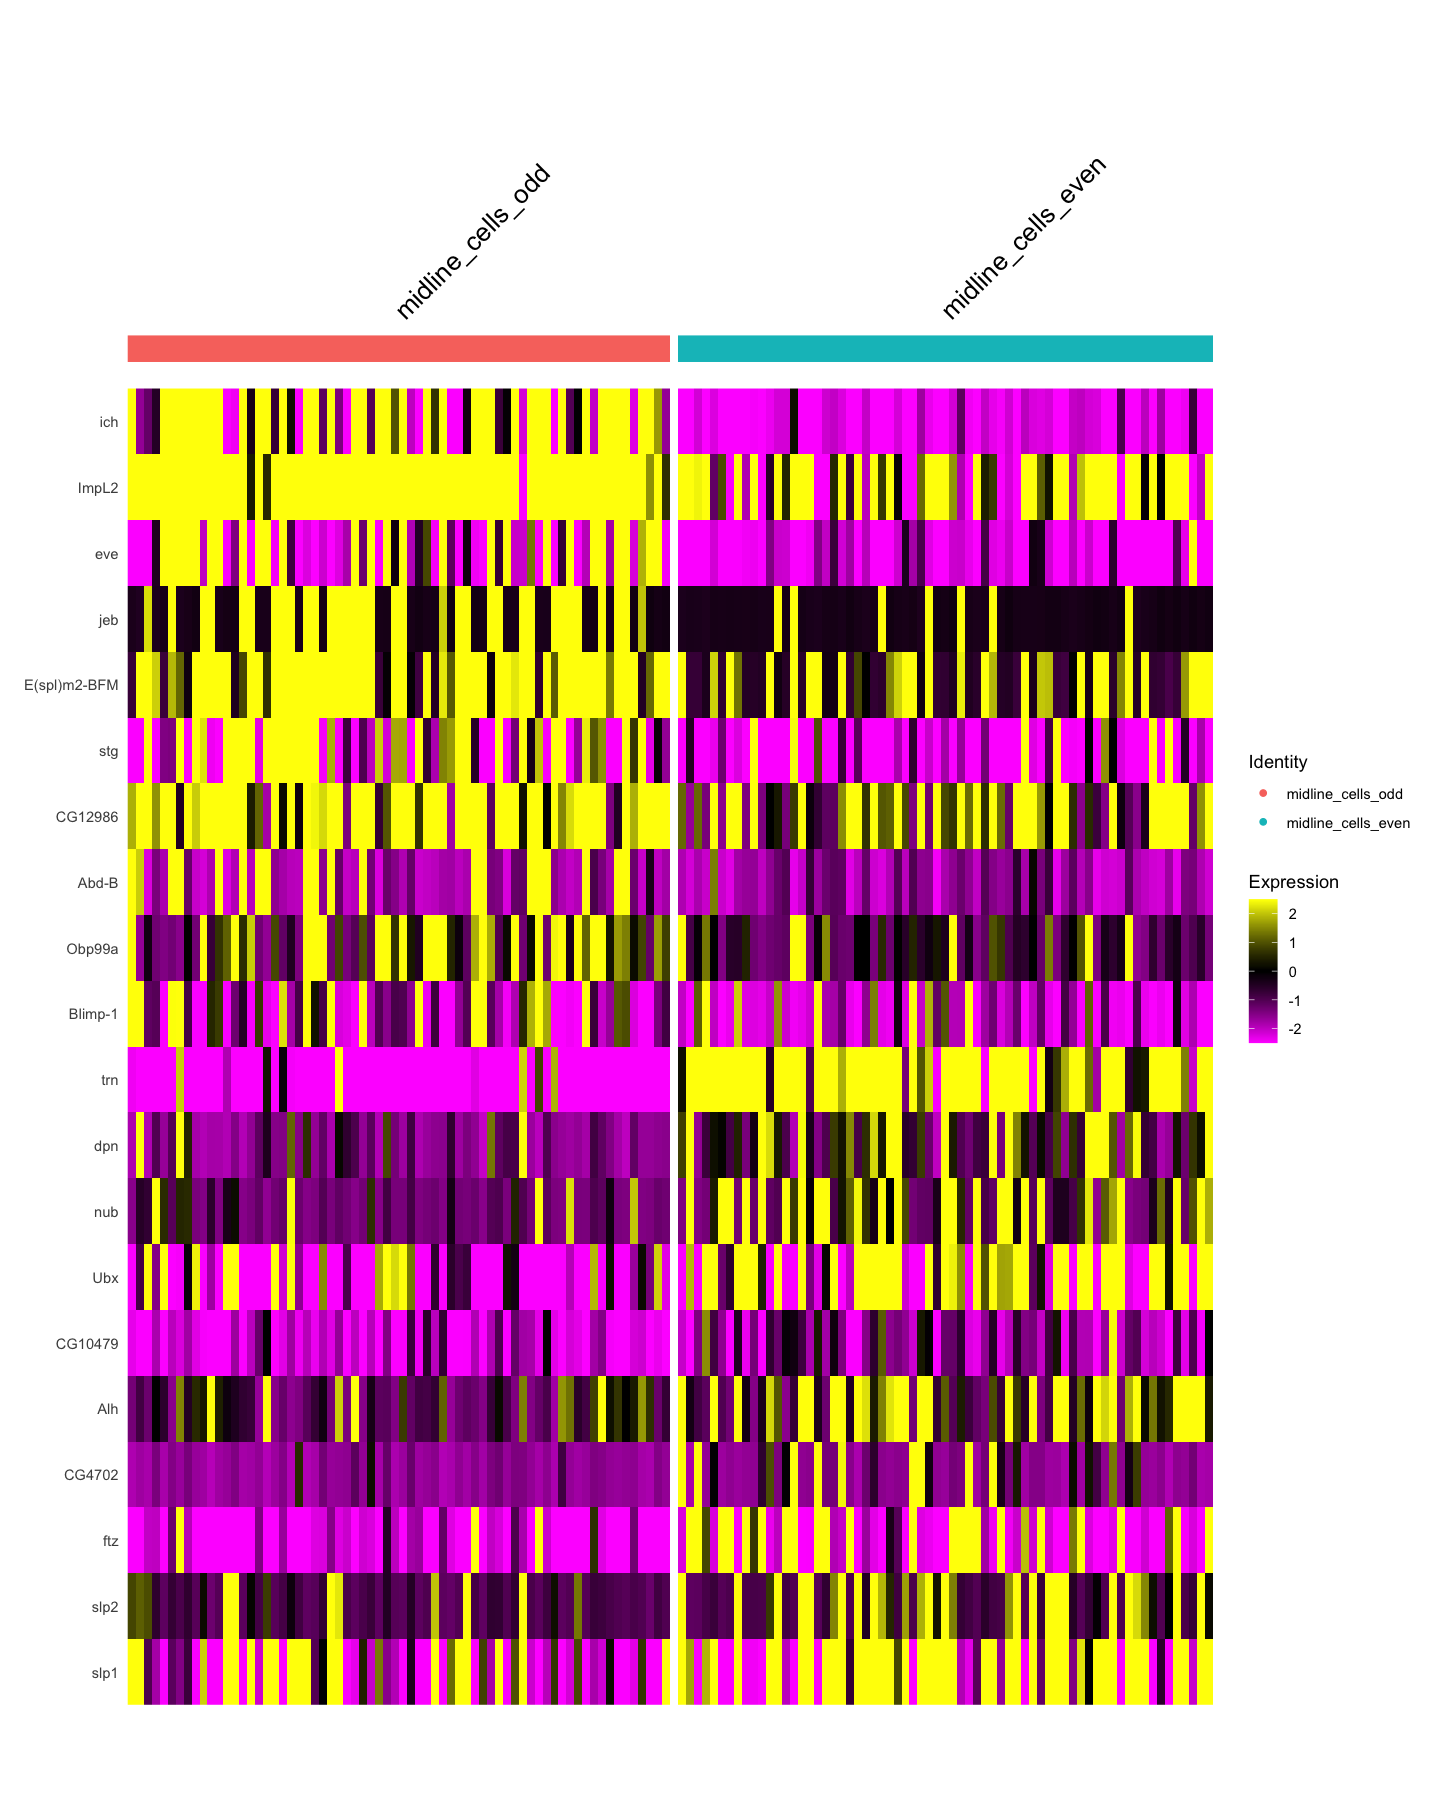

In [18]:
options(repr.plot.width=12, repr.plot.height=15)
fig <- DoHeatmap(seu_HQC_midline,  features = c(all.markers.midline.top10$gene))
fig
ggsave(fig, file = "./figures/07_subclustering_midline&polecells_manualID/midline_manualID_heatmap.eps", dpi = 300,  width = 12, height = 8)

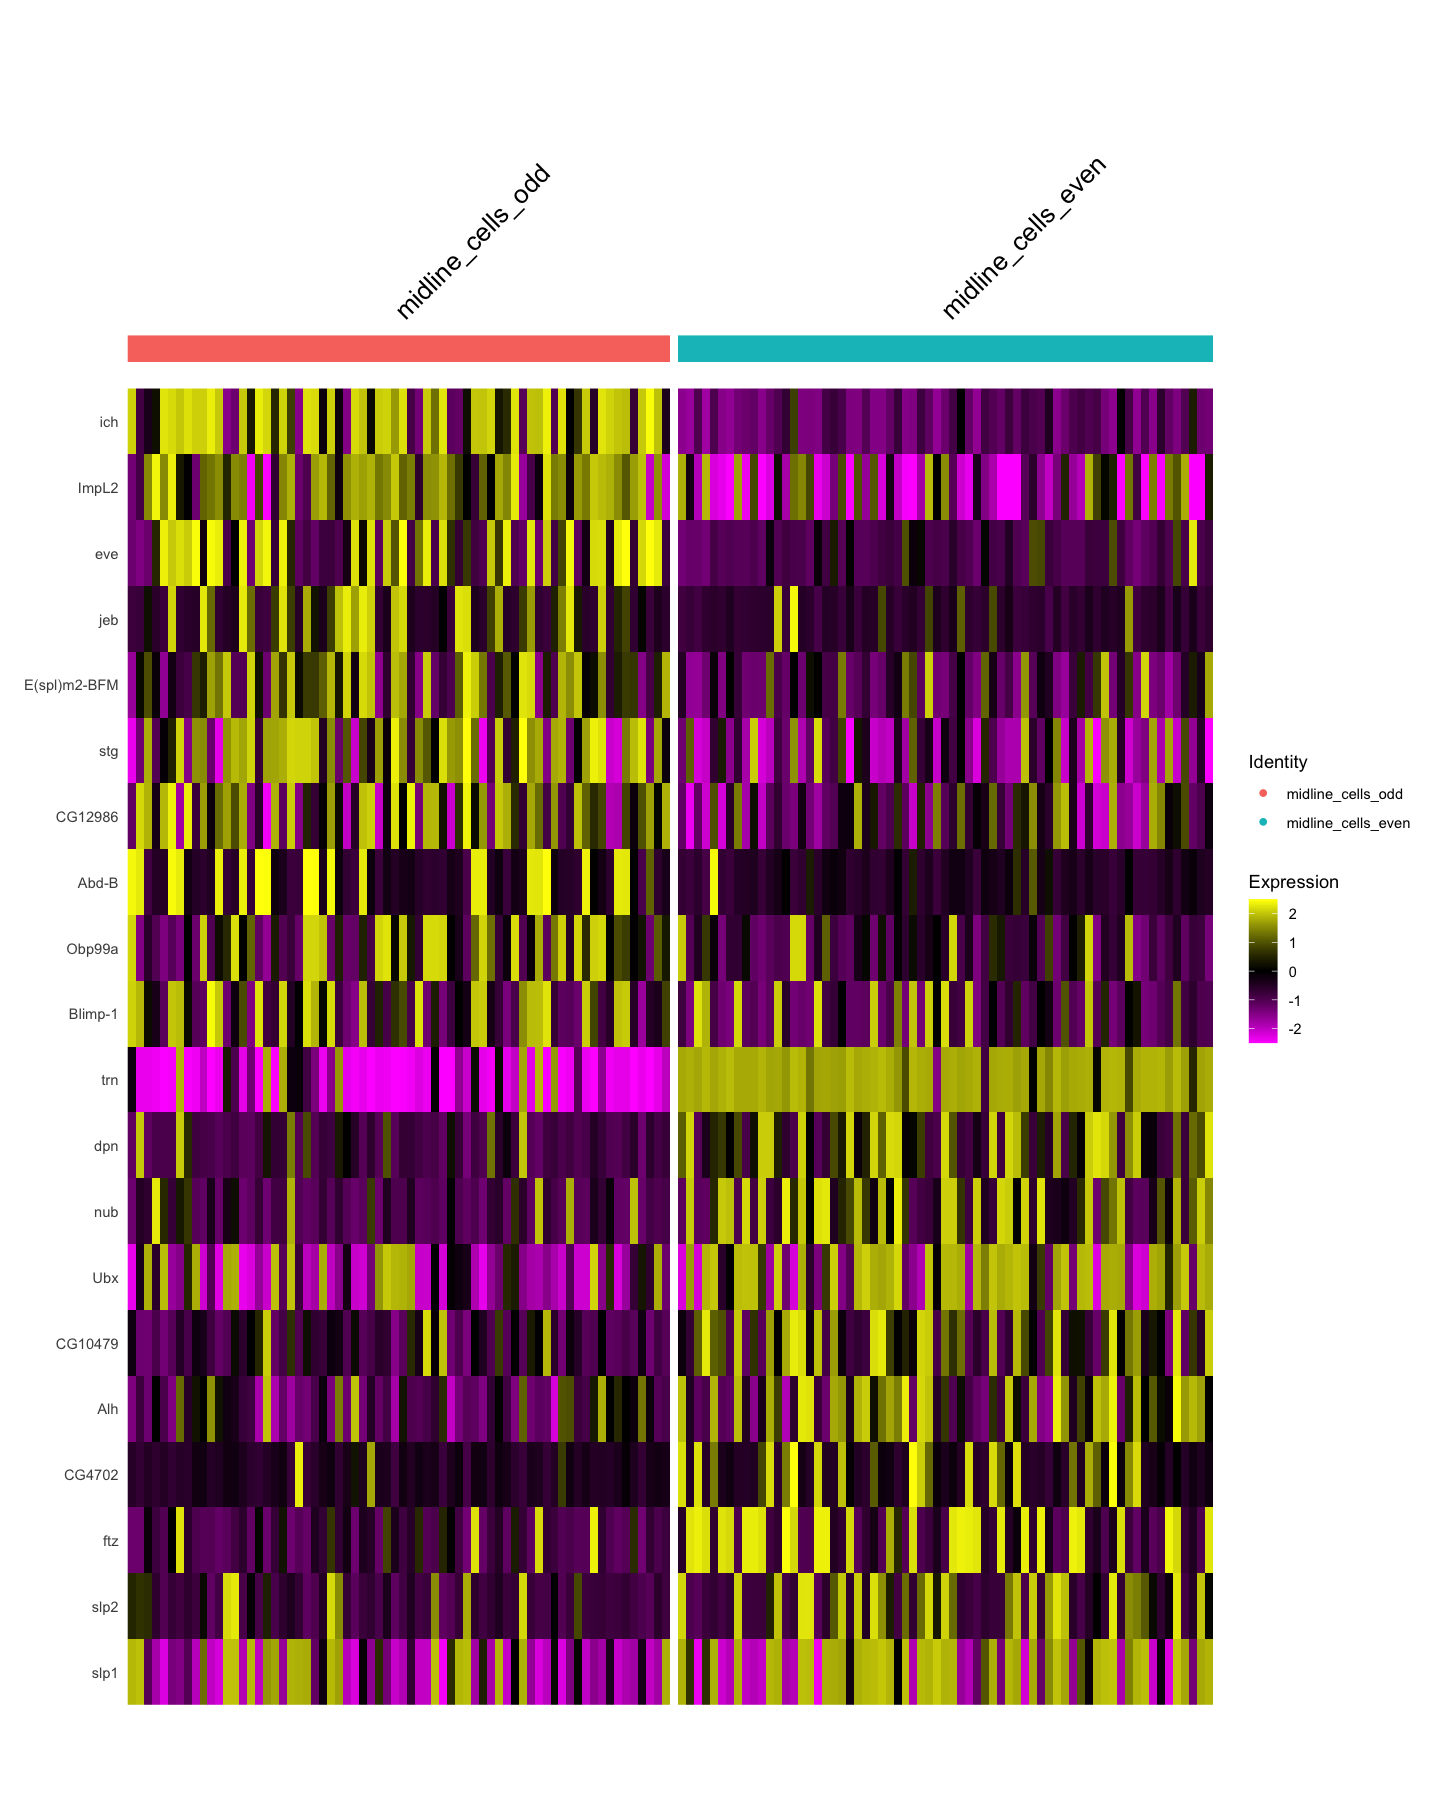

In [19]:
DefaultAssay(seu_HQC_midline) <- 'RNA'
seu_renorm <- suppressWarnings(SCTransform(seu_HQC_midline, vars.to.regress = c("percent.mt", "percent.rRNA"), verbose = FALSE))

options(repr.plot.width=12, repr.plot.height=15)
fig <- DoHeatmap(seu_renorm,  features = c(all.markers.midline.top10$gene))
fig
ggsave(fig, file = "./figures/07_subclustering_midline&polecells_manualID/midline_manualID_heatmap_renorm.eps", dpi = 300,  width = 12, height = 8)

In [20]:
write.table(all.markers, file = './subcluster_markers/markers_midlines.txt', sep = '\t')

In [21]:
saveRDS(seu_HQC_midline, file = '../../data/seurat_object/Set3/subclustering/seu_midline_subclustered.obj')

## Subclustering of Pole cells  was not performed

In [22]:
seu_HQC_pole <- subset(seu_HQC, ident = c("19"))
seu_HQC_pole

An object of class Seurat 
28756 features across 123 samples within 2 assays 
Active assay: SCT (11250 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [23]:
polecell_list <- colnames(seu_HQC_pole)
length(polecell_list)

[1] 123

In [24]:
ID <- rep("pole_cells", length=length(polecell_list)) 
ID

[1] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
  [6] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [11] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [16] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [21] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [26] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [31] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [36] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [41] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [46] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [51] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [56] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [61] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [66] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [71] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [76] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [81] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [86] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [91] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
 [96] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
[101] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
[106] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
[111] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
[116] "pole_cells" "pole_cells" "pole_cells" "pole_cells" "pole_cells"
[121] "pole_cells" "pole_cells" "pole_cells"

In [25]:
polecell_ID <- data.frame(polecell_list, ID)
head(polecell_ID)

,polecell_list,ID
,<chr>,<chr>
1,AACAAAGAGGACAGTC,pole_cells
2,AACAGGGTCGTGCGAC,pole_cells
3,AACCACAAGTGTACAA,pole_cells
4,AACGTCACAATAGGGC,pole_cells
5,AAGAACACAGTAGAGC,pole_cells
6,AAGTCGTGTCAGTCGC,pole_cells


In [26]:
polecell_ID <- polecell_ID %>% column_to_rownames("polecell_list")
head(polecell_ID)

,ID
,<chr>
AACAAAGAGGACAGTC,pole_cells
AACAGGGTCGTGCGAC,pole_cells
AACCACAAGTGTACAA,pole_cells
AACGTCACAATAGGGC,pole_cells
AAGAACACAGTAGAGC,pole_cells
AAGTCGTGTCAGTCGC,pole_cells


In [27]:
write.table(polecell_ID, file="./manual_ID_list/seu_HQC_polecell_manualID.txt", sep="\t",col.names=T,row.names=T,quote=F)

In [28]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tibble_3.0.5      dplyr_1.0.3       Matrix_1.3-2      data.table_1.13.6
[5] magrittr_2.0.1    ggplot2_3.3.3     Seurat_3.2.3     

loaded via a namespace (and not attached):
  [1] nlme_3.1-151          matrixStats_0.57.0    RcppAnnoy_0.0.18     
  [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
  [7] sctransform_0.3.2     tools_4.0.3           R6_2.5.1             
 [10] irlba_2.3.3           rpart_4.1-15          KernSmooth_2.23-18   
 [13] uwot_0.1.10           mgcv